# Import Packages

In [8]:
import os
gpu_index = 2

# Set GPU device based on index provided
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_index)

import yaml
import jax
import glob
import jax.random as random
import jax.numpy as jnp
from utils import *
# from jax import config
# config.update("jax_enable_x64", True)

from encoding_information.gpu_utils import limit_gpu_memory_growth
limit_gpu_memory_growth()
from encoding_information.information_estimation import *
from encoding_information.image_utils import *
from encoding_information.datasets.cfa_dataset import ColorFilterArrayDataset
from encoding_information import extract_patches
from encoding_information.models import PoissonNoiseModel
from tqdm import tqdm
import argparse
import equinox as eqx
import optax
import wandb
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import encoding_information


def load_config(config_file):
    with open(config_file, 'r') as file:
        config_data = yaml.safe_load(file)
    return config_data



In [9]:
from encoding_information.datasets import ColorFilterArrayDataset
from tqdm import tqdm
rescale_for_display = lambda x: np.clip((x / 255 * 3) ** (1 / 2.2), 0, 1)
tile_size = 128
dataset = ColorFilterArrayDataset('/home/anonymous_user/Workspace/PYTHON/EncodingInformation/color_filter_array/four_channel_images.zarr', tile_size=tile_size)
tile_indices = [76398, 83209, 79983]
tiles = dataset._tiles[tile_indices]
# take the central 40x40 square
center_square_size = 40
tiles = [tile[tile_size // 2 - center_square_size // 2:tile_size // 2 + center_square_size // 2,
                tile_size // 2 - center_square_size // 2:tile_size // 2 + center_square_size // 2] for tile in tiles]

patches = []
for tile in tiles:
    patches.append(tile.compute())

stride = 8
patch_size = 24
images = []
for patch in patches:
    for ii in range(0,patch.shape[0]-patch_size+1,stride):
        for jj in range(0,patch.shape[1]-patch_size+1,stride):
            images.append(patch[ii:ii+patch_size,jj:jj+patch_size,:])

paper_images = jnp.stack(images)/(255*3)

Exception ignored in: <function _xla_gc_callback at 0x7ff7f6d1e950>
Traceback (most recent call last):
  File "/home/anonymous_user/miniforge3/envs/InfoTheory/lib/python3.10/site-packages/jax/_src/lib/__init__.py", line 98, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


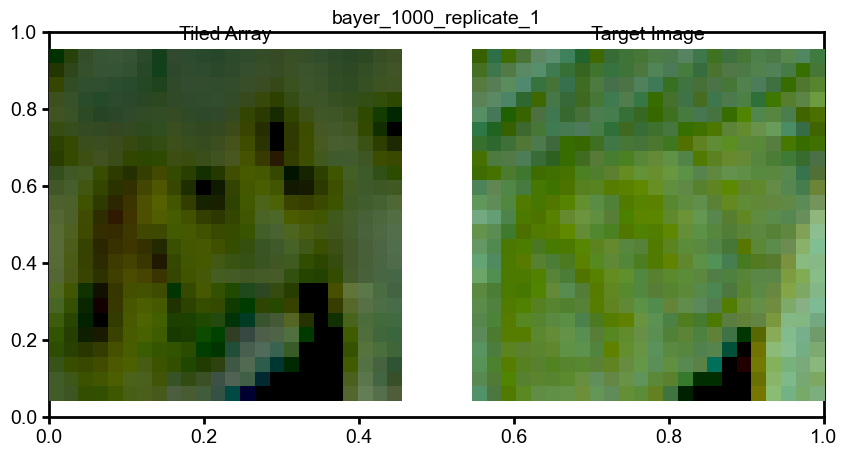

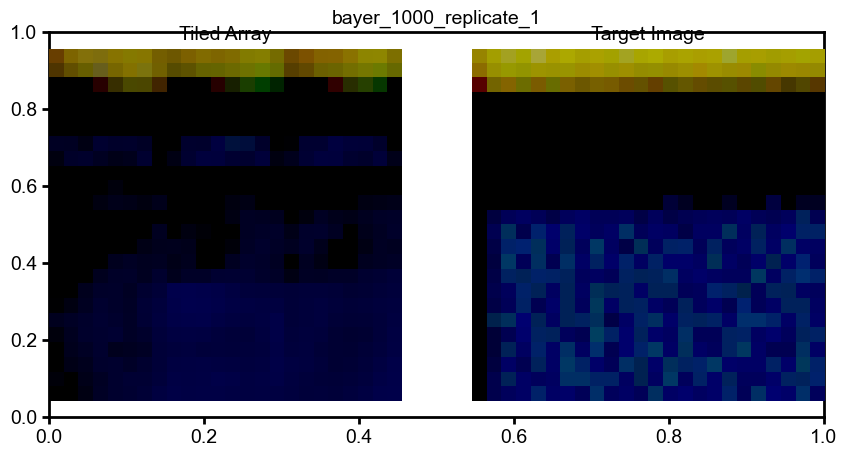

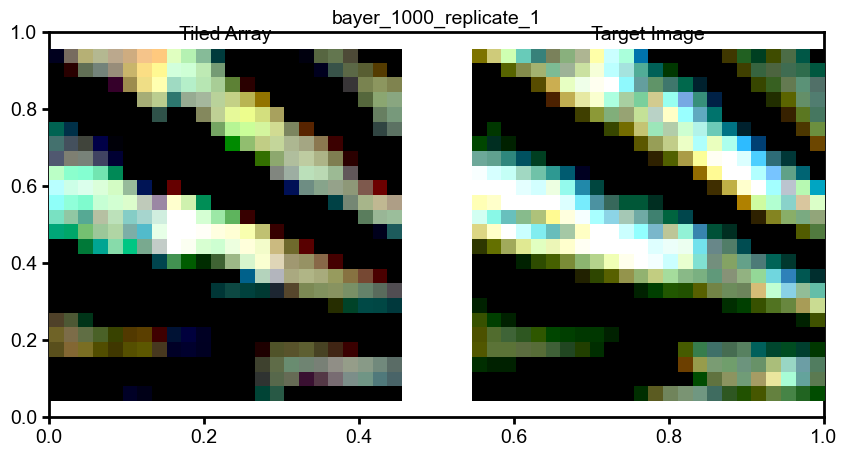

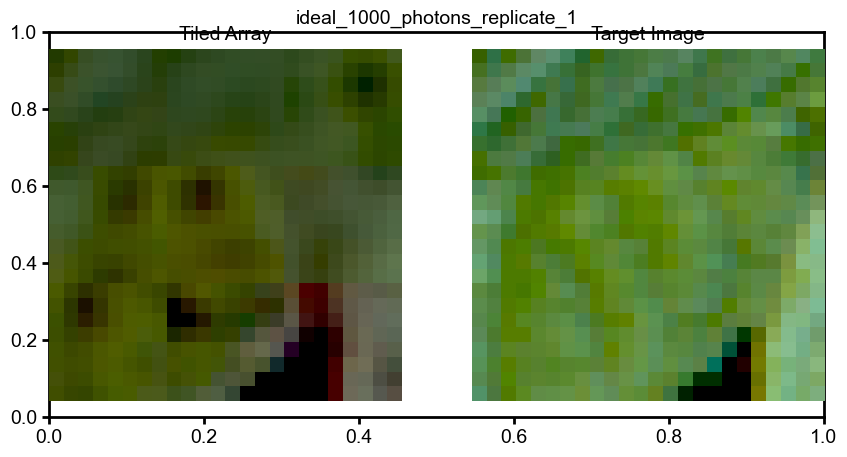

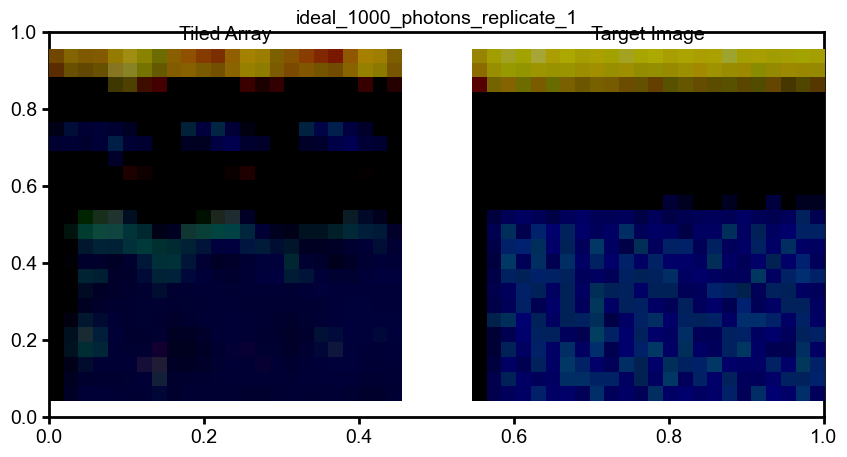

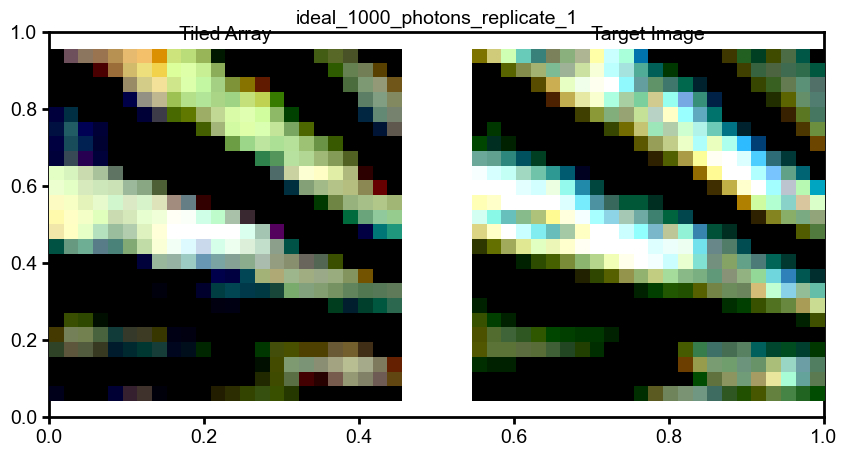

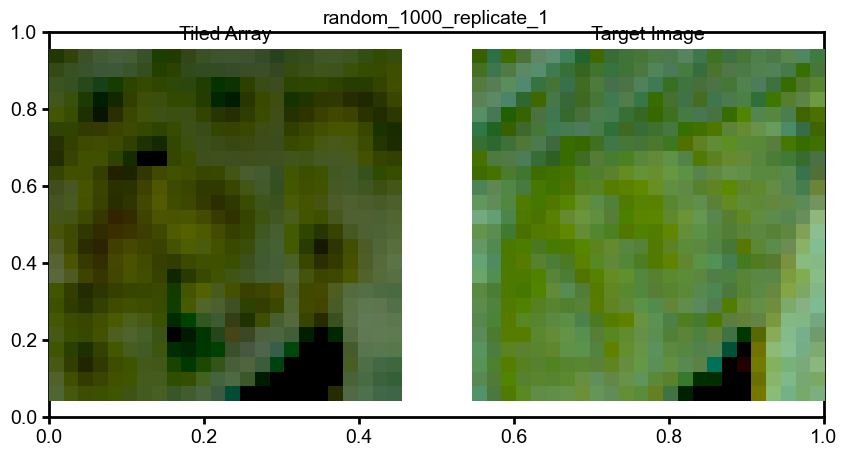

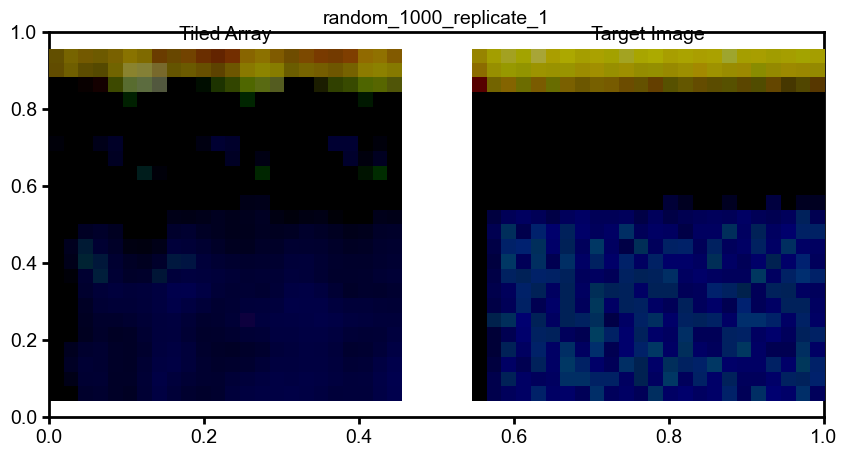

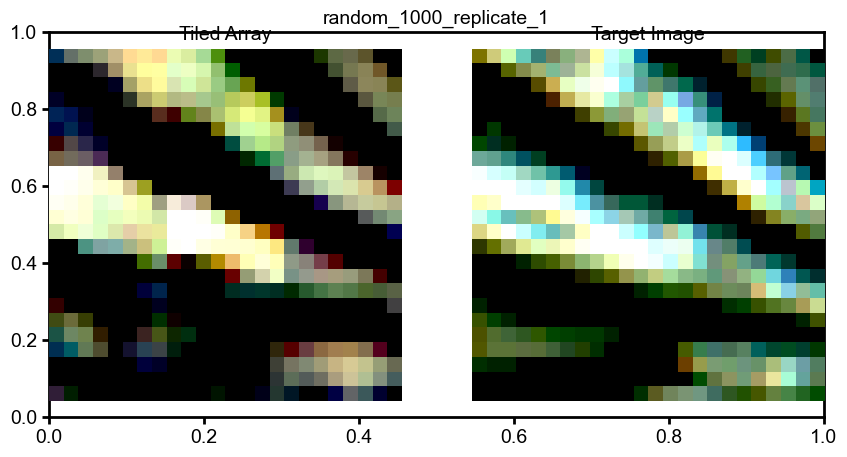

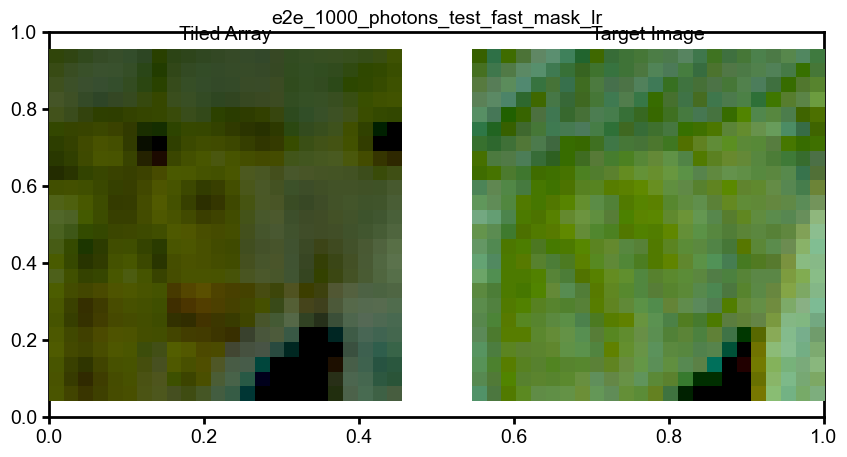

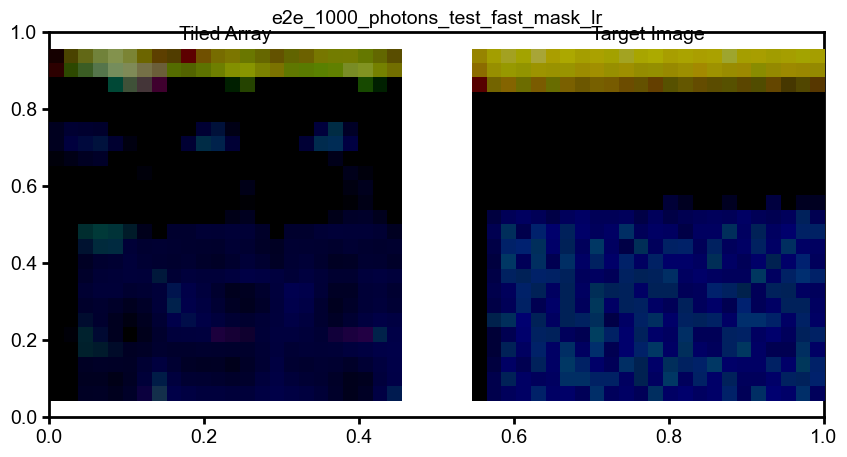

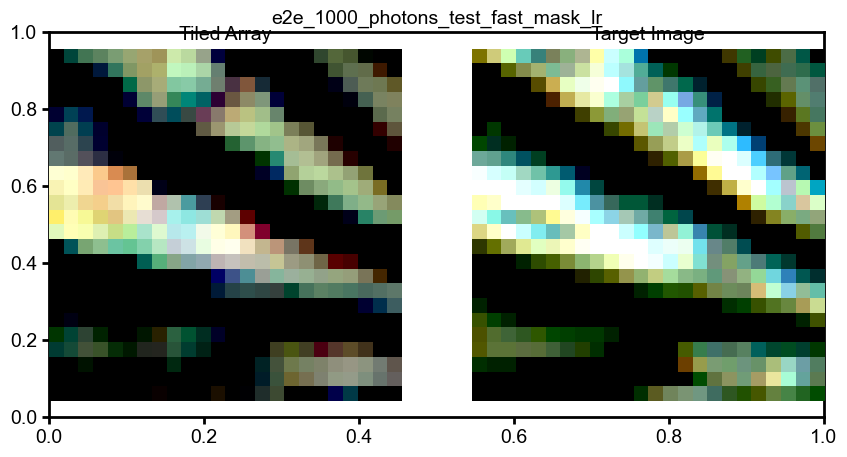

In [ ]:
configs = ['/home/anonymous_user/Workspace/PYTHON/EncodingInformation/color_filter_array/recon_configs/bayer_1000_replicate_1.yaml',
           '/home/anonymous_user/Workspace/PYTHON/EncodingInformation/color_filter_array/recon_configs/ideal_1000_photons_replicate_1.yaml',
           '/home/anonymous_user/Workspace/PYTHON/EncodingInformation/color_filter_array/recon_configs/random_1000_replicate_1.yaml',
           '/home/anonymous_user/Workspace/PYTHON/EncodingInformation/color_filter_array/e2e_configs/e2e_1000_photons_test_fast_mask_lr.yaml'
           ]
for config_path in configs:                
    # Load config
    with open(config_path, 'r') as file:
        h_params = yaml.safe_load(file)

    # Initialize the model
    model_key = jax.random.PRNGKey(h_params['model_key'])
    P, F, K = h_params['P'], h_params['F'], h_params['K']
    sensor_shape = (h_params['mask_size'], h_params['mask_size'], h_params['num_channels'])
    gamma = h_params['gamma']
    model = FullModel(sensor_shape, P, F, K, gamma, model_key)
    if h_params['mask_path']:
        mask = np.load(h_params['mask_path'])
        model = eqx.tree_at(lambda m: m.sensor_layer, model, replace=model.sensor_layer.update_w(mask))

    # Load the trained model
    model_dir = os.path.join("models", h_params['model_name'])

    model_files = [f for f in os.listdir(model_dir) if f.endswith('.eqx')]


    latest_model = max(model_files, key=lambda x: int(x.split('_')[1].split('.')[0]))
    if h_params['mask_path']:
        mask = np.load(os.path.join(model_dir, latest_model))
        model = eqx.tree_at(lambda m: m.sensor_layer, model, replace=model.sensor_layer.update_w(mask))
    model = eqx.tree_deserialise_leaves(os.path.join(model_dir, latest_model), model)

    data_mean = np.load(h_params['data_mean_path'])
    scale_factor = h_params['mean_photons'] / data_mean
    h_params['scale_factor'] = scale_factor
    noise_key = jax.random.PRNGKey(0)

    # Apply noise to images
    images = paper_images * scale_factor
    noise_key, subkey = jax.random.split(noise_key)
    images = images + jax.random.normal(subkey, shape=images.shape) * jnp.sqrt(images)
    images = (images / scale_factor).clip(0, 1)

    # Generate predictions
    alpha = jnp.full((images.shape[0], 1), 1e8)
    predictions = jax.vmap(model)(images, alpha)

    # Stitch the recons back together
    # Create an empty (24, 24, 3) array to hold the tiled output
    for k in range(len(patches)):
        tiled_array = np.zeros((24, 24, 3))
        input_array = predictions[k*9:(k+1)*9,:,:,:3]
        # Fill the (24, 24, 3) array in a 3x3 grid pattern
        for i in range(3):
            for j in range(3):
                # Calculate the starting indices for each patch
                start_y = i * 8
                start_x = j * 8
                # Place the patch in the correct location
                tiled_array[start_y:start_y + 8, start_x:start_x + 8, :] = input_array[i * 3 + j]*255
        
        # save the title_array
        save_dir = '/home/anonymous_user/Workspace/PYTHON/EncodingInformation/color_filter_array/figure_patches'
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        model_folder = config_path.split('/')[-1].split('.')[0]
        save_path = os.path.join(save_dir, model_folder)
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        np.save(os.path.join(save_path, f'patch_{k}.npy'), tiled_array)


        plt.figure(figsize=(10, 5))
        plt.title(config_path.split('/')[-1].split('.')[0])
        plt.subplot(1, 2, 1)
        plt.imshow(((tiled_array*3/255)**(1/2.2)).clip(0,1))
        plt.title('Tiled Array')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(((patches[k][8:32,8:32,:3]*3/255)**(1/2.2)).clip(0,1))
        plt.title('Target Image')
        plt.axis('off')

        plt.show()






Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


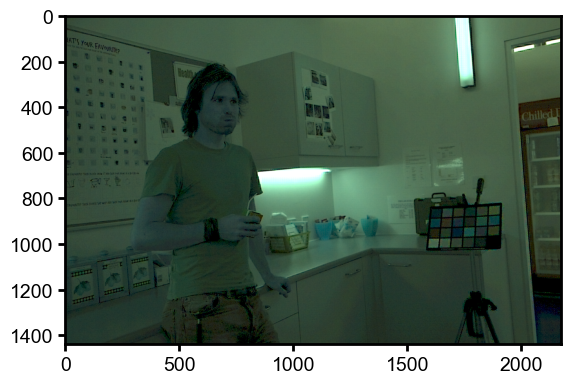

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
image = np.load('reconstructed_image.npy')
plt.imshow((3*image)**(1/2.2))
plt.show()

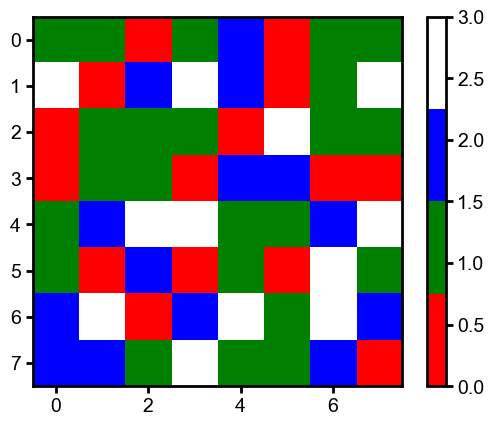

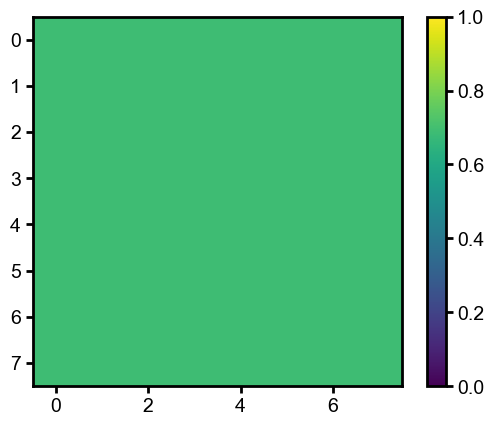

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import yaml
from utils import *
# import listed colormap
from matplotlib.colors import ListedColormap
cmap = ListedColormap(['red','green','blue','white'])

config_path = '/home/anonymous_user/Workspace/PYTHON/EncodingInformation/color_filter_array/recon_configs/random_1000_replicate_1.yaml'
# config_path = '/home/anonymous_user/Workspace/PYTHON/EncodingInformation/color_filter_array/ideal_configs/ideal_1000_photons.yaml'
# config_path = '/home/anonymous_user/Workspace/PYTHON/EncodingInformation/color_filter_array/e2e_configs/e2e_1000_photons_test_fast_mask_lr.yaml'
with open(config_path, 'r') as file:
    h_params = yaml.safe_load(file)


mask = np.load('/home/anonymous_user/Workspace/PYTHON/EncodingInformation/color_filter_array/models/random_filter_1000_photons_replicate_1/step_0095000.eqx')
# mask = np.load('/home/anonymous_user/Workspace/PYTHON/EncodingInformation/color_filter_array/models/ideal_1000_photons_replicate_1/step_0095000.eqx')
# mask = np.load('/home/anonymous_user/Workspace/PYTHON/EncodingInformation/color_filter_array/models/e2e_1000_photons_test_fast_mask_lr/step_0095000.eqx')

alpha = 1 + (95000*h_params['gamma'])**2
# mask = model.sensor_layer.w
softmax_mask = jax.nn.softmax(alpha*mask,axis=-1)

plt.figure()
plt.imshow(np.argmax(softmax_mask, axis=-1), cmap=cmap)
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(jnp.max(softmax_mask,axis = -1))
plt.clim(0,1)
plt.colorbar()
plt.show()
# np.save('filters/random_1000_photons.npy', mask)

In [ ]:
import os
import yaml
import jax
import jax.random as random
import jax.numpy as jnp
from utils import *
from jax import config
config.update("jax_enable_x64", True)

from encoding_information.gpu_utils import limit_gpu_memory_growth
limit_gpu_memory_growth()
gpu_index = 2
# Set GPU device based on index provided
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_index)

import jax.numpy as np
import numpy as onp
from tqdm import tqdm
from encoding_information.information_estimation import *
from encoding_information.image_utils import *
from encoding_information.datasets.cfa_dataset import ColorFilterArrayDataset
from encoding_information import extract_patches
from encoding_information.models import PoissonNoiseModel

def load_config(config_file):
    with open(config_file, 'r') as file:
        config_data = yaml.safe_load(file)
    return config_data

config_file = '/home/anonymous_user/Workspace/PYTHON/EncodingInformation/color_filter_array/mi_configs/e2e_1000_photons_fast_mask.yaml'
# Load parameters from config file
config_data = load_config(config_file)

# Dataset parameters
zarr_path = config_data['dataset']['zarr_path']
mean_photons = config_data['dataset']['mean_photons']
data_mean_path = config_data['dataset']['data_mean_path']
total_patches = config_data['dataset']['total_patches']
val_size = config_data['dataset']['val_size']
model_path = config_data['dataset']['model_path']
patch_size = config_data['dataset']['patch_size']
data_key = config_data['dataset']['data_key']
data_key = jax.random.PRNGKey(data_key)
model_key = config_data['dataset']['model_key']
model_key = jax.random.PRNGKey(model_key)
batch_size = config_data['dataset']['batch_size']
key = jax.random.PRNGKey(config_data['seeds']['data_seed'])

# Training parameters
epochs = config_data['training']['epochs']
N_models = config_data['training']['N_models']
num_bootstrap_samples = config_data['training']['num_bootstrap_samples']
data_seed = config_data['seeds']['data_seed']

# Output parameters
results_dir = config_data['output']['results_dir']
os.makedirs(results_dir, exist_ok=True)
save_name = config_data['output']['save_name']

# Split train and test data
test_loader, test_indices = create_patch_loader(
        zarr_path = os.path.join(zarr_path, 'test'), 
        batch_size=batch_size, 
        patch_size=(patch_size, patch_size),
        key=data_key, 
        total_patches=total_patches,
        num_workers=24
)

mean_last_channel = np.load(data_mean_path)
scale_factor = mean_photons / mean_last_channel
config_data['dataset']['scale_factor'] = scale_factor

# Define the model
sensor_model = SensorLayer((patch_size // 3, patch_size // 3), key=model_key)
sensor_pattern = np.load(model_path)
sensor_pattern = jnp.array(sensor_pattern, dtype=jnp.float64)
sensor_model = sensor_model.update_w(sensor_pattern)

# Collect the dataset
dataset = []
for images, _ in test_loader:
    measurements = jax.vmap(sensor_model)(images, 1e8 * jnp.ones((images.shape[0],))) * scale_factor
    dataset.append(measurements)
dataset = np.concatenate(dataset, axis=0)

# Squeeze the dataset
dataset = dataset.squeeze()

# Add Poisson noise to the dataset
noisy_dataset = dataset + jax.random.poisson(key, dataset, shape=dataset.shape)

# Split the noisy dataset into train and test sets
train_set = noisy_dataset[:int(len(noisy_dataset) * (1 - val_size))]
test_set = noisy_dataset[int(len(noisy_dataset) * (1 - val_size)):]


2024-10-22 09:45:30.188589: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-22 09:45:30.188716: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-22 09:45:30.300476: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-22 09:45:32.571563: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
model = PixelCNN()
model_seed = 0

# Train model
val_loss = model.fit(train_set, model_seed=model_seed, data_seed=data_seed, max_epochs=50, steps_per_epoch=1000, verbose=True, learning_rate=1e-3)


    # def fit(self, train_images, condition_vectors=None, learning_rate=1e-2, max_epochs=200, steps_per_epoch=100,  patience=40, 
    #         sigma_min=1, batch_size=64, num_val_samples=None, percent_samples_for_validation=0.1,  do_lr_decay=False, verbose=True,
    #         add_gaussian_noise=False, add_uniform_noise=True, model_seed=None, data_seed=None, use_positional_embedding=False,
    #         # deprecated
    #         seed=None,):

Initial validation NLL: 1539470.38


Epoch 1: 100%|██████████| 1000/1000 [00:36<00:00, 27.18it/s]


Epoch 1: validation NLL: 159.48


Epoch 2: 100%|██████████| 1000/1000 [00:32<00:00, 30.68it/s]


Epoch 2: validation NLL: 50.20


Epoch 3: 100%|██████████| 1000/1000 [00:33<00:00, 29.82it/s]


Epoch 3: validation NLL: 20.37


Epoch 4: 100%|██████████| 1000/1000 [00:33<00:00, 29.98it/s]


Epoch 4: validation NLL: 10.92


Epoch 5: 100%|██████████| 1000/1000 [00:32<00:00, 30.72it/s]


Epoch 5: validation NLL: 8.75


Epoch 6: 100%|██████████| 1000/1000 [00:33<00:00, 30.00it/s]


Epoch 6: validation NLL: 8.49


Epoch 7: 100%|██████████| 1000/1000 [00:33<00:00, 29.98it/s]


Epoch 7: validation NLL: 8.33


Epoch 8: 100%|██████████| 1000/1000 [00:32<00:00, 30.40it/s]


Epoch 8: validation NLL: 8.22


Epoch 9: 100%|██████████| 1000/1000 [00:32<00:00, 30.40it/s]


Epoch 9: validation NLL: 8.13


Epoch 10: 100%|██████████| 1000/1000 [00:33<00:00, 30.24it/s]


Epoch 10: validation NLL: 7.70


Epoch 11: 100%|██████████| 1000/1000 [00:32<00:00, 30.82it/s]


Epoch 11: validation NLL: 7.56


Epoch 12: 100%|██████████| 1000/1000 [00:32<00:00, 30.54it/s]


Epoch 12: validation NLL: 7.41


Epoch 13: 100%|██████████| 1000/1000 [00:32<00:00, 30.37it/s]


Epoch 13: validation NLL: 6.99


Epoch 14: 100%|██████████| 1000/1000 [00:32<00:00, 30.68it/s]


Epoch 14: validation NLL: 6.81


Epoch 15: 100%|██████████| 1000/1000 [00:32<00:00, 30.41it/s]


Epoch 15: validation NLL: 6.53


Epoch 16: 100%|██████████| 1000/1000 [00:32<00:00, 30.40it/s]


Epoch 16: validation NLL: 6.35


Epoch 17: 100%|██████████| 1000/1000 [00:32<00:00, 30.65it/s]


Epoch 17: validation NLL: 6.90


Epoch 18: 100%|██████████| 1000/1000 [00:32<00:00, 30.50it/s]


Epoch 18: validation NLL: 6.17


Epoch 19: 100%|██████████| 1000/1000 [00:33<00:00, 30.30it/s]


Epoch 19: validation NLL: 5.86


Epoch 20: 100%|██████████| 1000/1000 [00:33<00:00, 29.62it/s]


Epoch 20: validation NLL: 5.69


Epoch 21: 100%|██████████| 1000/1000 [00:33<00:00, 30.15it/s]


Epoch 21: validation NLL: 5.65


Epoch 22: 100%|██████████| 1000/1000 [00:33<00:00, 30.08it/s]


Epoch 22: validation NLL: 5.53


Epoch 23: 100%|██████████| 1000/1000 [00:32<00:00, 30.50it/s]


Epoch 23: validation NLL: 5.54


Epoch 24: 100%|██████████| 1000/1000 [00:33<00:00, 30.14it/s]


Epoch 24: validation NLL: 5.42


Epoch 25: 100%|██████████| 1000/1000 [00:33<00:00, 30.19it/s]


Epoch 25: validation NLL: 5.40


Epoch 26: 100%|██████████| 1000/1000 [00:33<00:00, 29.86it/s]


Epoch 26: validation NLL: 5.36


Epoch 27: 100%|██████████| 1000/1000 [00:33<00:00, 30.20it/s]


Epoch 27: validation NLL: 5.47


Epoch 28: 100%|██████████| 1000/1000 [00:33<00:00, 30.28it/s]


Epoch 28: validation NLL: 5.33


Epoch 29: 100%|██████████| 1000/1000 [00:32<00:00, 30.33it/s]


Epoch 29: validation NLL: 5.30


Epoch 30: 100%|██████████| 1000/1000 [00:33<00:00, 29.85it/s]


Epoch 30: validation NLL: 5.29


Epoch 31: 100%|██████████| 1000/1000 [00:33<00:00, 29.53it/s]


Epoch 31: validation NLL: 5.31


Epoch 32: 100%|██████████| 1000/1000 [00:33<00:00, 29.52it/s]


Epoch 32: validation NLL: 5.29


Epoch 33: 100%|██████████| 1000/1000 [00:34<00:00, 29.11it/s]


Epoch 33: validation NLL: 5.24


Epoch 34: 100%|██████████| 1000/1000 [00:33<00:00, 29.75it/s]


Epoch 34: validation NLL: 5.25


Epoch 35: 100%|██████████| 1000/1000 [00:33<00:00, 29.50it/s]


Epoch 35: validation NLL: 5.25


Epoch 36: 100%|██████████| 1000/1000 [00:33<00:00, 29.60it/s]


Epoch 36: validation NLL: 5.24


Epoch 37: 100%|██████████| 1000/1000 [00:33<00:00, 29.41it/s]


Epoch 37: validation NLL: 5.33


Epoch 38: 100%|██████████| 1000/1000 [00:33<00:00, 29.70it/s]


Epoch 38: validation NLL: 5.23


Epoch 39: 100%|██████████| 1000/1000 [00:33<00:00, 29.65it/s]


Epoch 39: validation NLL: 5.20


Epoch 40: 100%|██████████| 1000/1000 [00:33<00:00, 29.97it/s]


Epoch 40: validation NLL: 5.23


Epoch 41: 100%|██████████| 1000/1000 [00:34<00:00, 29.20it/s]


Epoch 41: validation NLL: 5.21


Epoch 42: 100%|██████████| 1000/1000 [00:33<00:00, 29.95it/s]


Epoch 42: validation NLL: 5.24


Epoch 43: 100%|██████████| 1000/1000 [00:32<00:00, 31.19it/s]


Epoch 43: validation NLL: 5.30


Epoch 44: 100%|██████████| 1000/1000 [00:31<00:00, 31.25it/s]


Epoch 44: validation NLL: 5.19


Epoch 45: 100%|██████████| 1000/1000 [00:31<00:00, 31.36it/s]


Epoch 45: validation NLL: 5.24


Epoch 46: 100%|██████████| 1000/1000 [00:33<00:00, 30.07it/s]


Epoch 46: validation NLL: 5.19


Epoch 47: 100%|██████████| 1000/1000 [00:39<00:00, 25.16it/s]


Epoch 47: validation NLL: 5.19


Epoch 48: 100%|██████████| 1000/1000 [00:35<00:00, 28.12it/s]


Epoch 48: validation NLL: 5.19


Epoch 49: 100%|██████████| 1000/1000 [00:37<00:00, 26.95it/s]


Epoch 49: validation NLL: 5.22


Epoch 50: 100%|██████████| 1000/1000 [00:36<00:00, 27.06it/s]


Epoch 50: validation NLL: 5.19


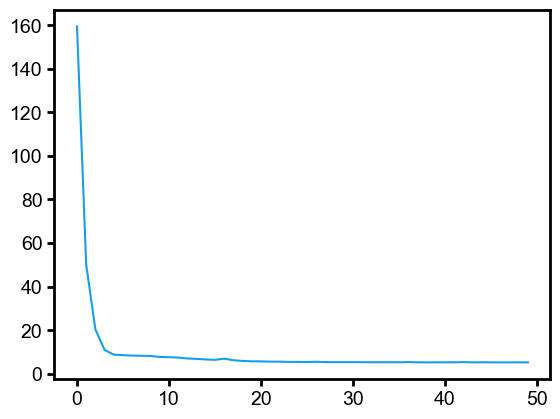

In [ ]:
import matplotlib.pyplot as plt
plt.plot(val_loss[1:])
plt.show()

In [ ]:
file = '/home/anonymous_user/Workspace/PYTHON/EncodingInformation/color_filter_array/mi_results/e2e_1000_photons_fast_mask.npz'


results = np.load(file)
data = {}
data['average_nlls'] = results['average_nlls']
data['partial_test_set_nlls_by_model'] = results['partial_test_set_nlls_by_model']
data['test_set_sizes'] = results['test_set_sizes']
data['mean_nll_dist_by_size'] = results['mean_nll_dist_by_size']
data['mean_nll_dist_by_size_conf_low'] = results['mean_nll_dist_by_size_conf_low']
data['mean_nll_dist_by_size_conf_high'] = results['mean_nll_dist_by_size_conf_high']
data['mutual_information'] = results['mutual_information']
data['mutual_information_conf_low'] = results['mutual_information_conf_low']
data['mutual_information_conf_high'] = results['mutual_information_conf_high']
data['filter_matrix'] = results['filter_matrix']

In [ ]:
plt.figure()
plt.plot(data['average_nlls'])
plt.show()

In [ ]:
import os
gpu_index = 2

# Set GPU device based on index provided
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_index)

import yaml
import jax
import glob
import jax.random as random
import jax.numpy as jnp
from utils import *
# from jax import config
# config.update("jax_enable_x64", True)

from encoding_information.gpu_utils import limit_gpu_memory_growth
limit_gpu_memory_growth()
from encoding_information.information_estimation import *
from encoding_information.image_utils import *
from encoding_information.datasets.cfa_dataset import ColorFilterArrayDataset
from encoding_information import extract_patches
from encoding_information.models import PoissonNoiseModel
from tqdm import tqdm
import argparse
import equinox as eqx
import optax
import wandb
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import encoding_information


def load_config(config_file):
    with open(config_file, 'r') as file:
        config_data = yaml.safe_load(file)
    return config_data



In [ ]:
from glob import glob


def analytic_multivariate_gaussian_entropy(cov_matrix):
    """
    Numerically stable computation of the analytic entropy of a multivariate gaussian
    using JAX.
    """
    d = cov_matrix.shape[0]
    eigvals = jnp.linalg.eigvalsh(cov_matrix)
    eigvals = jnp.where(eigvals <= 0, jnp.finfo(eigvals.dtype).eps, eigvals)
    entropy = 0.5 * d * jnp.log(2 * jnp.pi * jnp.e) + 0.5 * jnp.sum(jnp.log(eigvals))
    return entropy / d

def estimate_conditional_entropy(images):
    epsilon = 1e-8
    gaussian_approx = 0.5 * (jnp.log(2 * jnp.pi * jnp.e) + jnp.log(images + epsilon))
    gaussian_approx = jnp.where(images <= 0, jnp.zeros_like(images), gaussian_approx)
    per_image_entropies = jnp.mean(gaussian_approx, axis=1)
    h_y_given_x = jnp.mean(per_image_entropies)
    return h_y_given_x

def estimate_mi(images):
    """
    Estimate mutual information for given images using JAX.
    """
    noisy_images = add_noise(images)  # Make sure to define or convert `add_noise` to work with JAX tensors
    h_y_given_x = estimate_conditional_entropy(images)
    h_y = analytic_multivariate_gaussian_entropy(jnp.cov(noisy_images.T))
    mi = (h_y - h_y_given_x) / jnp.log(jnp.array(2.))
    return mi

def add_noise(images):
    return images + jax.random.normal(jax.random.PRNGKey(0), shape=images.shape) * jnp.sqrt(jnp.clip(images, 1e-8, None))



In [ ]:
# Load config
config_path = '/home/anonymous_user/Workspace/PYTHON/EncodingInformation/color_filter_array/ideal_configs/ideal_1000_photons.yaml'
with open(config_path, 'r') as file:
    h_params = yaml.safe_load(file)

# Initialize the model
model_key = jax.random.PRNGKey(h_params['model_key'])
sensor_shape = (h_params['mask_size'], h_params['mask_size'], h_params['num_channels'])
gamma = h_params['gamma']
model = SensorLayer(sensor_shape, replicates=3, key=model_key)


# Initialize the optimizer
optimizer = optax.adamw(learning_rate=h_params["mask_lr"], b1=h_params["b1"], b2=h_params["b2"])
opt_state = optimizer.init(eqx.filter(model, eqx.is_array))

# Instantiate the data loader
batch_size = h_params['n_batch']
patch_size = (h_params['mask_size']*3, 3*h_params['mask_size'])
data_path = h_params['data_path']
data_key = jax.random.PRNGKey(h_params['data_key'])

# Create train and test loaders
# Create train and test loaders separately

test_loader, test_indices = create_patch_loader(
    zarr_path=os.path.join(data_path, 'val'), 
    batch_size=batch_size, 
    patch_size=patch_size, 
    key=data_key, 
    total_patches=int(h_params['total_patches'] * h_params['val_size']),
    num_workers=24
)

# Iterate through the train loader to get the mean of the last channel over the entire dataset
if h_params['data_mean_path'] is None:
    train_loader_iter = iter(train_loader)
    cum_mean = 0
    count = 0
    for images, _ in tqdm(train_loader_iter):
        cum_mean += jnp.mean(images[:,:,:,3])
        count += 1
    mean_last_channel = cum_mean / count
else:
    mean_last_channel = np.load(h_params['data_mean_path'])
scale_factor = h_params['mean_photons'] / mean_last_channel
h_params['scale_factor'] = scale_factor




In [ ]:
@eqx.filter_jit
def validate_model(model, images, alpha):
    measurements = jax.vmap(model)(images, alpha)
    # flatten the measurements
    measurements = measurements.reshape(measurements.shape[0], -1)
    MI = estimate_mi(measurements)
    return -MI


Processing images:   0%|          | 0/3 [00:00<?, ?it/s]

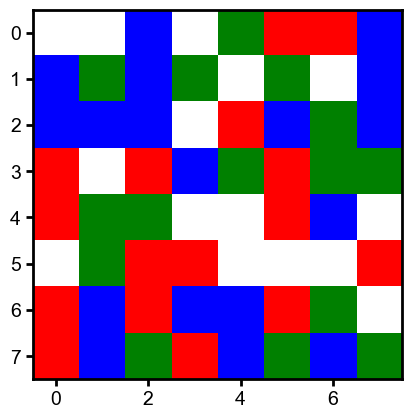

Processing images:  33%|███▎      | 1/3 [00:08<00:17,  8.88s/it]

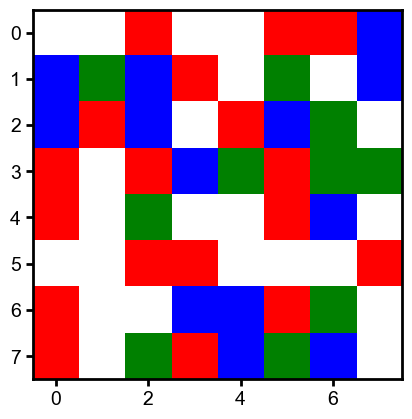

Processing images:  67%|██████▋   | 2/3 [00:17<00:08,  8.66s/it]

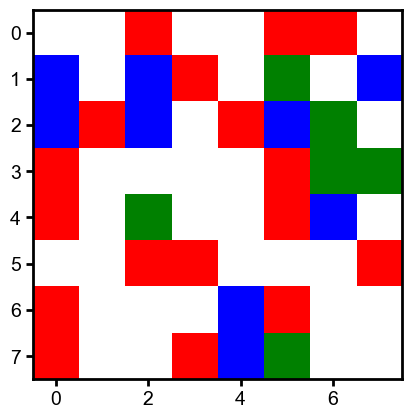

Processing images: 100%|██████████| 3/3 [00:26<00:00,  8.83s/it]


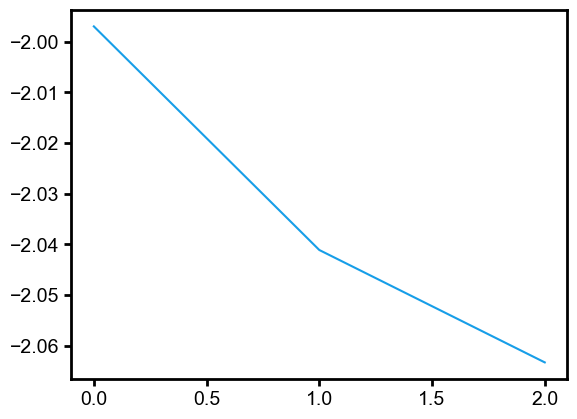

In [21]:
cmap = ListedColormap(['red','green','blue','white'])
from glob import glob
img_files = glob('/home/anonymous_user/Workspace/PYTHON/EncodingInformation/color_filter_array/wandb/run-20241017_153733-acj1dc7r/files/media/images/*.png')
sorted_img_files = sorted(img_files, key=lambda x: int(x.split('sensor_')[1].split('_')[0]))
sorted_img_files = [sorted_img_files[i] for i in [0, 5, 10]]

val_losses = []
for file in tqdm(sorted_img_files, desc="Processing images"):

    img = plt.imread(file)
    sensor = img[120:-120,128:-110,:]
    # print(sensor.shape)
    y_down = sensor.shape[0]//8
    x_down = sensor.shape[1]//8
    sensor = sensor[20::y_down,20::x_down,:]

    # Convert the sensor array to an 8 x 8 x 4 one-hot encoded array
    one_hot_sensor = np.zeros((8, 8, 4), dtype=int)
    sensor = sensor>0.1
    for i in range(8):
        for j in range(8):
            pixel = sensor[i, j, :]
            if np.array_equal(pixel, [1, 0, 0, 1]):  # Red
                one_hot_sensor[i, j, 0] = 1
            elif np.array_equal(pixel, [0, 1, 0, 1]):  # Green
                one_hot_sensor[i, j, 1] = 1
            elif np.array_equal(pixel, [0, 0, 1, 1]):  # Blue
                one_hot_sensor[i, j, 2] = 1
            elif np.array_equal(pixel, [1, 1, 1, 1]):  # White
                one_hot_sensor[i, j, 3] = 1
            else:
                print(pixel, i, j)

    model = model.update_w(one_hot_sensor)

    plt.figure()
    plt.imshow(jnp.argmax(model.w, axis=-1), cmap=cmap)
    plt.show()

    val_loss = 0
    val_count = 0
    for val_images, val_targets in test_loader:
        val_count += 1
        # scale the images and add noise
        val_images = val_images*scale_factor
        # add gaussian approximation of poisson noise
        alpha = 1e8
        alpha = jnp.full((val_images.shape[0], 1), alpha)
        val_loss += validate_model(model, val_images, alpha)
    val_loss /= val_count
    # print(f"Validation loss: {val_loss}")
    val_losses.append(val_loss)
    # np.save('val_losses.npy', val_losses)

plt.plot(val_losses)
plt.show()

In [ ]:
img_files = glob('/home/anonymous_user/Workspace/PYTHON/EncodingInformation/color_filter_array/wandb/run-20241017_153733-acj1dc7r/files/media/images/*.png')

In [18]:
np.save('filters/ideal_1000_photons_initialization.npy', model.w)